In [1]:
%load_ext autoreload 
%autoreload 2 

In [13]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf
import json

from src.data_processing.pipelines.LSTMPipe import LSTMPipe
from src.models.experimental_dropout_StackedLSTM import StackedLSTM




In [3]:
# print gpus available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [67]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'
# MODEL_PATH = "/projects/p31961/ENIGMA/results/experiments/dopamine_full_sequence_stacked_lstm_01/models/dopamine_full_sequence_stacked_lstm_01"

# locald
# DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
# MODEL_PATH = '/Users/mds8301/Development/enigma/results/experiments/full_sequence_stacked_lstm_01/models/full_sequence_stacked_lstm_01'

In [77]:
processor = LSTMPipe(DATA_PATH)
processor.read_raw_data(dropna=True)
processor.raw_data=processor.raw_data.reset_index(drop=True)


mouse_id          0
day               0
event             0
sensor            0
time              0
trial             0
signal            0
action            0
latency           0
sex               0
learning_phase    0
trial_count       0
dtype: int64

In [78]:
with open('/projects/p31961/ENIGMA/results/experiments/full_sequence_stacked_lstm_01/subjects.json', 'r') as f:
    subjects = json.load(f)
subjects

{'training': [8, 3, 10, 13, 4, 1, 7, 6, 2], 'dev': [0, 11], 'test': [5, 9, 12]}

In [79]:
training_subjects = subjects['training']
dev_subjects = subjects['dev']
test_subjects = subjects['test']

training_query = ' or '.join([f"mouse_id=={subject}" for subject in training_subjects])
dev_query = ' or '.join([f"mouse_id=={subject}" for subject in dev_subjects])
test_query = ' or '.join([f"mouse_id=={subject}" for subject in test_subjects])

def split_by_subjects_query(subjects):
    query = ' or '.join([f"mouse_id=={subject}" for subject in subjects])
    x, y = processor.raw_data.query(query).drop(columns ="signal"), processor.raw_data.query(query)['signal']
    return x, y

processor.X_train, processor.y_train = split_by_subjects_query(training_subjects)
processor.X_dev, processor.y_dev = split_by_subjects_query(dev_subjects)
processor.X_test, processor.y_test = split_by_subjects_query(test_subjects)


In [80]:
processor.transorm_data()


pandas.core.series.Series

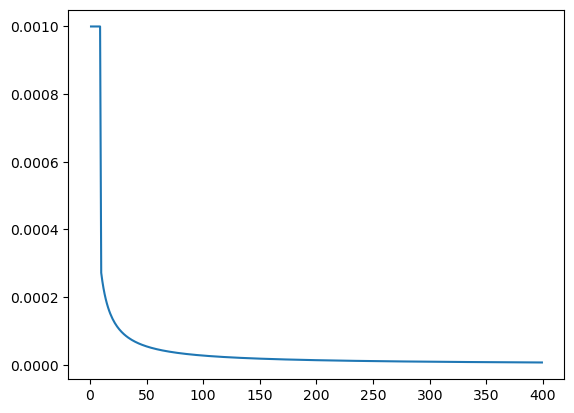

In [81]:
def lr_schedular(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(1.)/epoch
epochs = range(1,400,1)
lrs = np.array([lr_schedular(e, 0.001) for e in epochs])
plt.plot(epochs, lrs)
# plot loss



In [57]:
# X_train_tensor = tf.convert_to_tensor(processor.X_train, dtype=tf.float32)
# y_train_tensor = tf.convert_to_tensor(processor.y_train, dtype=tf.float32)
# X_dev_tensor = tf.convert_to_tensor(processor.X_dev, dtype=tf.float32)
# y_dev_tensor = tf.convert_to_tensor(processor.y_dev, dtype=tf.float32)
# X_test_tensor = tf.convert_to_tensor(processor.X_test, dtype=tf.float32)
# y_test_tensor = tf.convert_to_tensor(processor.y_test, dtype=tf.float32)

In [82]:
model = StackedLSTM(
    sequence_length=90,
    num_features=processor.X_train.shape[1],
    lstm_units=processor.X_train.shape[1] * 2
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam', loss='mse', metrics=[
    'mae', 'mse', 'mape', 'cosine_similarity'])



# learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(
#     lr_schedular, verbose=1)

model.fit(X_train_tensor, y_train_tensor,
          epochs=5,
          validation_data=(X_dev_tensor, y_dev_tensor))

Epoch 1/5


2023-08-29 14:24:51.220772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 14:24:51.222146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 14:24:51.223320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1158/1160 [============================>.] - ETA: 0s - loss: 0.8539 - mae: 0.7035 - mse: 0.8539 - mape: 153.2103 - cosine_similarity: -0.0121

2023-08-29 14:24:59.872242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-29 14:24:59.873700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-29 14:24:59.874889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1160/1160 [==============================] - 10s 6ms/step - loss: 0.8537 - mae: 0.7034 - mse: 0.8537 - mape: 153.1391 - cosine_similarity: -0.0125 - val_loss: 0.9355 - val_mae: 0.7401 - val_mse: 0.9355 - val_mape: 121.7019 - val_cosine_similarity: 9.5168e-04
Epoch 2/5
 912/1160 [======================>.......] - ETA: 1s - loss: 0.8566 - mae: 0.7040 - mse: 0.8566 - mape: 129.8103 - cosine_similarity: -0.0136

KeyboardInterrupt: 

In [59]:
model.history.history

{'loss': [0.8536112904548645,
  0.8532909154891968,
  0.8529773354530334,
  0.8529106974601746,
  0.8528148531913757],
 'mae': [0.7033472657203674,
  0.7032100558280945,
  0.7029657959938049,
  0.703197181224823,
  0.7031916975975037],
 'mse': [0.8536112904548645,
  0.8532909154891968,
  0.8529773354530334,
  0.8529106974601746,
  0.8528148531913757],
 'mape': [169.95840454101562,
  162.35690307617188,
  150.4809112548828,
  157.1604766845703,
  150.184814453125],
 'cosine_similarity': [-0.011523300781846046,
  -0.012800129130482674,
  -0.012099490500986576,
  -0.01274623442441225,
  -0.012854024767875671],
 'val_loss': [0.935465395450592,
  0.9358685612678528,
  0.9355065822601318,
  0.935401976108551,
  0.9356196522712708],
 'val_mae': [0.7401448488235474,
  0.7398573756217957,
  0.7411807179450989,
  0.7408512830734253,
  0.7400203347206116],
 'val_mse': [0.935465395450592,
  0.9358685612678528,
  0.9355065822601318,
  0.935401976108551,
  0.9356196522712708],
 'val_mape': [122.1097

<tf.Tensor: shape=(3712, 18), dtype=float64, numpy=
array([[-1.05235347,  0.56745356, -0.38797426, ...,  1.        ,
         1.        ,  0.        ],
       [-1.05235347,  0.56745356,  0.24508318, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05235347,  0.56745356,  0.87814059, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.52250117,  0.08199894, -0.35782866, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.86183418,  0.08199894,  0.27522877, ...,  0.        ,
         0.        ,  1.        ],
       [-1.31727962,  0.08199894,  0.90828619, ...,  0.        ,
         1.        ,  0.        ]])>